**PROBLEM STATEMENT**

**The bit-flip code and the sign-flip code are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.**

1. Build a circuit to prepare the Bell state: $$\frac{(|00\rangle+|11\rangle)}{\sqrt{2}}$$
2. Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).
3. Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that all the possible choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!
4. Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.



**Below is my approach to the problem above**

*Step 1: Make the necessary imports*

In [1]:
from qiskit import QuantumCircuit, Aer, execute, BasicAer
from math import pi
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit import QuantumCircuit, execute,IBMQ
from qiskit.tools.monitor import job_monitor

In [14]:
import random

*Step 2: Create the Bell State. This can be created by applying a Hadamard gate to the 1st qubit followed by a CNOT*
*with control qubit as the 1st qubit and target qubit as the 2nd qubit. This step is just to show the Bell State.*    

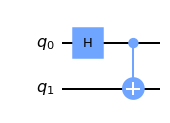

In [3]:
q = QuantumRegister(2,'q')
circuit = QuantumCircuit(q)
circuit.h(q[0])
circuit.cx(q[0],q[1])
circuit.draw('mpl')

**Now comes the main part of the question where we need to build the circuit for error correction. The problem states that we need to add either a I,X or Z (a single unitary) just before CNOT to both the qubits with non-zero probability. We will do this by making all combinations of these (I, X or Z) on both qubits to occur with same probability which means that the probability of error is not 0. To do this, we will do random sampling on the list of gates [I,X,Z] for both the qubits so that any error is somewhat equally likely to occur.**

**Claim: It is enough to just implement a phase or sign flip code for the 1st qubit and a bit flip code for the 2nd qubit, we will require 4 auxiliary qubits, 2 for each qubit. The circuit implementation is below**

In [15]:
Gate_choices_for_errors = ['I','X','Z']
q = QuantumRegister(6,'q')
c = ClassicalRegister(2,'c')

circuit = QuantumCircuit(q,c)

#Below is the initial Hadamard gate which we had in the circuit we created for the Bell State
circuit.h(q[0])

#phase flip code for q[0]
circuit.cx(q[0],q[2])
circuit.cx(q[0],q[3])

circuit.h(q[0])
circuit.h(q[2])
circuit.h(q[3]) 

#Now we need to randomly add an error gate to the first qubit, which the operations of the phase flip code should be able to
#detect and correct.
error_gate1 = random.choice(Gate_choices_for_errors) 
if error_gate1=='Z':
    circuit.z(q[0])
if error_gate1=='X':
    circuit.x(q[0])
if error_gate1=='I':
    circuit.i(q[0])
    
circuit.h(q[0])
circuit.h(q[2])
circuit.h(q[3])

circuit.cx(q[0],q[2])
circuit.cx(q[0],q[3])
circuit.ccx(q[3],q[2],q[0])
circuit.barrier(q)

#bit code for q[1]
circuit.cx(q[1],q[4])
circuit.cx(q[1],q[5])

error_gate2 = random.choice(Gate_choices_for_errors) 
if error_gate2=='Z':
    circuit.z(q[1])
if error_gate2=='X':
    circuit.x(q[1])
if error_gate2=='I':
    circuit.i(q[1])


circuit.cx(q[1],q[4])
circuit.cx(q[1],q[5])
circuit.ccx(q[5],q[4],q[1])

circuit.cx(q[0],q[1])
circuit.barrier()
circuit.measure(q[0],c[0]) 
circuit.measure(q[1],c[1]) 

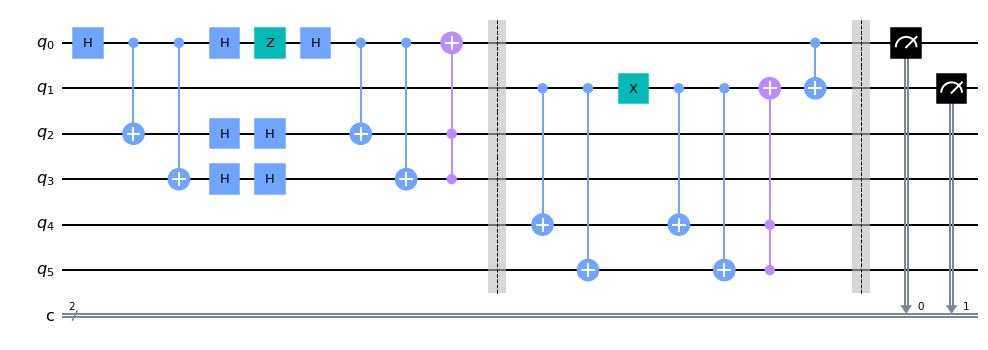

In [16]:
circuit.draw('mpl')

In [17]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=1500)

counts = job.result().get_counts()

print(counts)

# backend1 = Aer.get_backend('statevector_simulator')
# result = execute(circuit,backend1).result() # Do the simulation, returning the result
# out_state = result.get_statevector()
# print(out_state)

{'11': 750, '00': 750}


**We can see from above measurements that though we introduced error gates randomly, we still get the Bell State, which means our circuit has been able to detect and correct the errors**

**Reason why this worked: On the first qubit, after Hadamard gate, the qubit is in equal superposition of |0> and |1>, which means it is in the state |+>. This state is an eigenstate of the Pauli X gate with eigenvector as 1. This implies that X gate has no impact on this qubit after the Hadamard gate. Identity operator anyway does not have any impact on it. The only gate which can alter it is the Z gate which flips |1> to -|1> and would turn the state |+> to |->. Thus, a phase or sign flip code is sufficient to correct it**

**Similarly for the 2nd qubit, it is in |0> state before CNOT. |0> is an eigenstate of Z with eigenvalue 1. This means that Z and I (Identity) have no impact on it. The only gate which has an impact on it, is the X gate, which would turn it into |1> (bit flip). Thus, the bit flip code can detect and correct it easily**

**THANK YOU SO MUCH! THIS HAS BEEN A GREAT LEARNING EXPERIENCE. :)**